Name: Vijaykumar Maraviya

Student Number: 1006040320

In [1]:
import gym
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from sklearn.preprocessing import KBinsDiscretizer
from itertools import product
import collections

### Mountain Car environment and discretization of state space

Obeservation space is two-dimensional (position and velocity) and continuous:

Num | Observation  | Min  | Max  
----|--------------|------|----   
0   | position     | -1.2 | 0.6
1   | velocity     | -0.07| 0.07

They are discretized into 12 bins.

The agent can take 3 actions (push left, no push, push right):

Num | Action|
----|-------------|
0   | push left   |
1   | no push     |
2   | push right  |

The reward of -1 is given for each time step, until the goal position of 0.5 is reached. The episode ends when agent reach 0.5 position, or if 200 iterations are reached.

In [2]:
mc_env = gym.make('MountainCar-v0')
mc_env.reset()

# lower bounds of state space
lower_bounds = mc_env.observation_space.low

# upper bounds of state space
upper_bounds = mc_env.observation_space.high

n_bins = (12, 12)

# discretize the state
def mc_discretizer(car_position, car_velocity):
    est = KBinsDiscretizer(n_bins=n_bins,
                           encode='ordinal', 
                           strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int, est.transform([[car_position, car_velocity]])[0]))

# action_space
mc_action_space = [0,1,2]

# discretized state_space
mc_state_space = []
for s in product(range(12), range(12)):
    mc_state_space.append(s)

### performance test

The test function runs specified number of episodes using a given policy and plots rewards.

In [10]:
def test(Q, eps, num_episodes = 1000):
    rewards = np.zeros(num_episodes)
    for i in range(num_episodes):
        totalReward = 0
        observation = mc_discretizer(*mc_env.reset())
        done = False
        while not done:
            action =  e_greedy(Q, eps, observation)
            observation_, reward, done, info = mc_env.step(action)            
            observation = mc_discretizer(*observation_)
            totalReward += reward
        rewards[i] = totalReward
    
    print(f"Average reward over {num_episodes} episodes: {np.average(rewards):.2f}")
    print(f"number of successes (reward >= -199) in {num_episodes} episodes: {np.sum(np.where(rewards >= -199, 1, 0))}")
    
    plt.figure(2, figsize=[10,5])
    plt.plot(rewards)
    plt.xlabel('episode number')
    plt.ylabel('reward')
    plt.show()

### Implementation

This function selects an action using e-greedy policy for a given Q

In [4]:
def e_greedy(Q, eps, S):
    # random action with probability eps
    if np.random.random() < eps:
        return np.random.choice([0,1,2])
    
    # greedy action otherwise
    act_vals = np.array([Q[(S,a)] for a in [0,1,2]])
    return np.random.choice(np.where(act_vals == act_vals.max())[0])

In [5]:
def decay_eps(current_eps, eps_min, eps_dec):
    new_eps = current_eps - eps_dec
    return max(new_eps, eps_min)

# Task 1: TD(0)

### a. on-policy SARSA

In [6]:
def on_policy_SARSA(env, state_space, action_space, descritizer,
                    max_episodes = 50000, GAMMA = 1.0,
                    EPS_MAX = 1.0, EPS_MIN = 0.05,
                    ALPHA = 0.1):
    
    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX
        
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
    
    scores = []
    
    # loop for max_episodes
    for episode in range(max_episodes):
        
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        # choose A
        A = e_greedy(Q, eps, S)
        
        score = 0
        done = False
        
        while not done:            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            score += R
            
            # choose A_next
            A_next = e_greedy(Q, eps, S_next)
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + ALPHA*(R + GAMMA*Q[(S_next, A_next)] - Q[(S,A)])
            
            # next S, A
            S, A = S_next, A_next
        
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])

        if episode % 1000 == 0:
            print('episode:', episode, '| avg_reward for last 1000 episodes: %.1f' % avg_score)
        
    return Q, scores

In [7]:
# on-policy SARSA
Q_on_policy_sarsa, rewards_on_policy_sarsa = on_policy_SARSA(env = mc_env,
                                                            state_space = mc_state_space,
                                                            action_space = mc_action_space,
                                                            descritizer = mc_discretizer, 
                                                            max_episodes = 20000)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -198.8
episode: 7000 | avg_reward for last 1000 episodes: -193.4
episode: 8000 | avg_reward for last 1000 episodes: -185.2
episode: 9000 | avg_reward for last 1000 episodes: -173.4
episode: 10000 | avg_reward for last 1000 episodes: -154.4
episode: 11000 | avg_reward for last 1000 episodes: -171.8
episode: 12000 | avg_reward for last 1000 episodes: -150.2
episode: 13000 | avg_reward for last 1000 episodes: -166.0
episode: 14000 | avg_reward for last 1000 episodes: -158.0
episode: 15000 | avg_reward for last 1000 episodes: -171.2
episode: 16000 | avg_reward for last 1000 episodes: -175.9
episode: 1

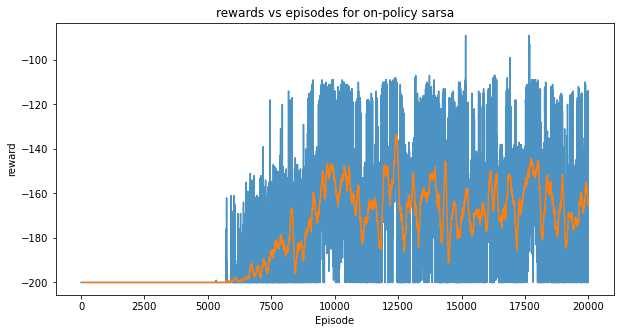

In [8]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_on_policy_sarsa)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for on-policy sarsa')
plt.show()

Average reward over 100 episodes: -147.19
number of successes (reward >= -199) in 100 episodes: 100


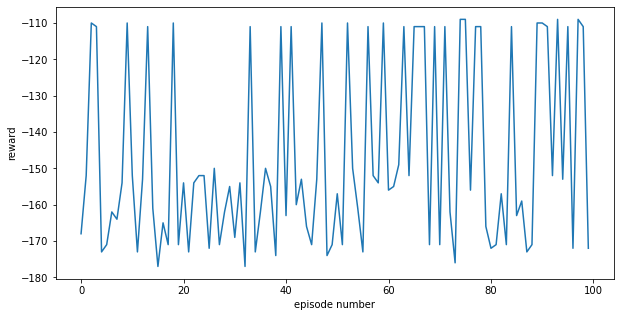

In [11]:
# test the learned policy
test(Q_on_policy_sarsa, 0, 100)

### b. on-policy expected SARSA

In [7]:
def calculate_expected_Q(Q, S, eps):
    A_greedy = np.argmax([Q[(S,a)] for a in [0,1,2]])
    
    if A_greedy == 0:
        expected_value = (1-eps + (eps/3))*Q[(S,0)] + (eps/3)*Q[(S,1)] + (eps/3)*Q[(S,2)]
    elif A_greedy == 1:
        expected_value = (1-eps + (eps/3))*Q[(S,1)] + (eps/3)*Q[(S,0)] + (eps/3)*Q[(S,2)]
    else:
        expected_value = (1-eps + (eps/3))*Q[(S,2)] + (eps/3)*Q[(S,1)] + (eps/3)*Q[(S,0)]
    
    return expected_value

def on_policy_expected_SARSA(env, state_space, action_space, descritizer,
                            max_episodes = 50000, GAMMA = 1.0,
                            EPS_MAX = 1.0, EPS_MIN = 0.05,
                            ALPHA = 0.1):
    
    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX
    
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
    
    scores = []
            
    # loop for max_episodes
    for episode in range(max_episodes):
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        score = 0
        done = False
        while not done: 
            # choose A (behaviour policy e-greedy)
            A = e_greedy(Q, eps, S)
            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            score += R
            
            # expected value (target policy e-greedy)
            Q_expected  = calculate_expected_Q(Q, S_next, eps)
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + ALPHA*(R + GAMMA*Q_expected - Q[(S,A)])
            
            # next S, A
            S = S_next
        
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])

        if episode % 1000 == 0:
            print('episode:', episode, '| avg_reward for last 1000 episodes: %.1f' % avg_score)
            
    return Q, scores

In [8]:
# on-policy expected SARSA
Q_on_policy_expected_sarsa, rewards_on_policy_expected_sarsa = on_policy_expected_SARSA(env = mc_env,
                                                                                      state_space = mc_state_space,
                                                                                      action_space = mc_action_space,
                                                                                      descritizer = mc_discretizer, 
                                                                                      max_episodes = 20000)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -199.7
episode: 7000 | avg_reward for last 1000 episodes: -195.4
episode: 8000 | avg_reward for last 1000 episodes: -191.2
episode: 9000 | avg_reward for last 1000 episodes: -179.0
episode: 10000 | avg_reward for last 1000 episodes: -155.6
episode: 11000 | avg_reward for last 1000 episodes: -161.4
episode: 12000 | avg_reward for last 1000 episodes: -164.4
episode: 13000 | avg_reward for last 1000 episodes: -180.5
episode: 14000 | avg_reward for last 1000 episodes: -172.6
episode: 15000 | avg_reward for last 1000 episodes: -178.1
episode: 16000 | avg_reward for last 1000 episodes: -159.3
episode: 1

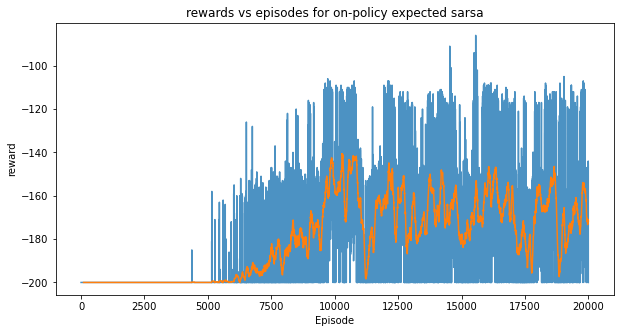

In [10]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_on_policy_expected_sarsa)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for on-policy expected sarsa')
plt.show()

Average reward over 100 episodes: -156.68
number of successes (reward >= -199) in 100 episodes: 91


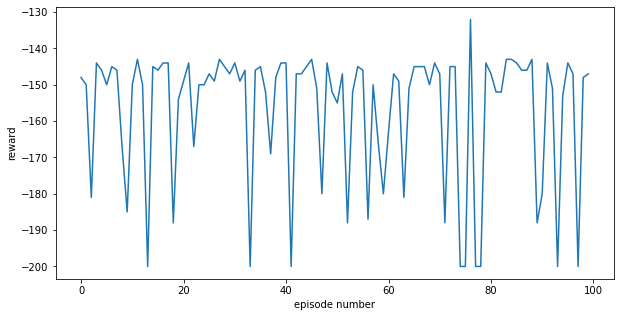

In [13]:
# test the learned policy
test(Q_on_policy_expected_sarsa, 0, 100)

### c. off-policy expected SARSA with a greedy control policy (Q-Learning)

In [8]:
def off_policy_expected_sarsa(env, state_space, action_space, descritizer, 
                 max_episodes = 10000, GAMMA = 1.0,
                 EPS_MAX = 1.0, EPS_MIN = 0.05,
                 ALPHA = 0.1):
    
    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX
    
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
    
    scores = []
            
    # loop for max_episodes
    for episode in range(max_episodes):
        
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        score = 0
        done = False
        while not done: 
            # choose A (behaviour policy e-greedy)
            A = e_greedy(Q, eps, S)
            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            score += R
            
            # target policy is greedy w.r.t to Q
            Q_max = max([ Q[(S_next, a)] for a in action_space])
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + ALPHA*(R + GAMMA*Q_max - Q[(S,A)])
            
            # next S, A
            S = S_next
            
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])

        if episode % 1000 == 0:
            print('episode:', episode, '| avg_reward for last 1000 episodes: %.1f' % avg_score)
        
    return Q, scores

In [9]:
# off-policy expected SARSA
Q_off_policy_expected_sarsa, rewards_off_policy_expected_sarsa = off_policy_expected_sarsa(env = mc_env,
                                                                                      state_space = mc_state_space,
                                                                                      action_space = mc_action_space,
                                                                                      descritizer = mc_discretizer, 
                                                                                      max_episodes = 20000)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -199.7
episode: 7000 | avg_reward for last 1000 episodes: -199.2
episode: 8000 | avg_reward for last 1000 episodes: -196.4
episode: 9000 | avg_reward for last 1000 episodes: -190.3
episode: 10000 | avg_reward for last 1000 episodes: -157.3
episode: 11000 | avg_reward for last 1000 episodes: -157.5
episode: 12000 | avg_reward for last 1000 episodes: -168.9
episode: 13000 | avg_reward for last 1000 episodes: -162.1
episode: 14000 | avg_reward for last 1000 episodes: -171.1
episode: 15000 | avg_reward for last 1000 episodes: -169.9
episode: 16000 | avg_reward for last 1000 episodes: -175.2
episode: 1

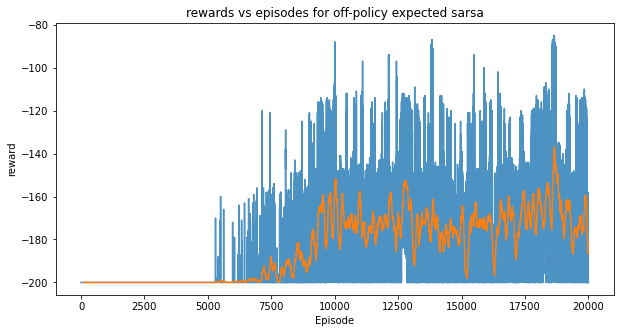

In [11]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_off_policy_expected_sarsa)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for off-policy expected sarsa')
plt.show()

Average reward over 100 episodes: -182.92
number of successes (reward >= -199) in 100 episodes: 55


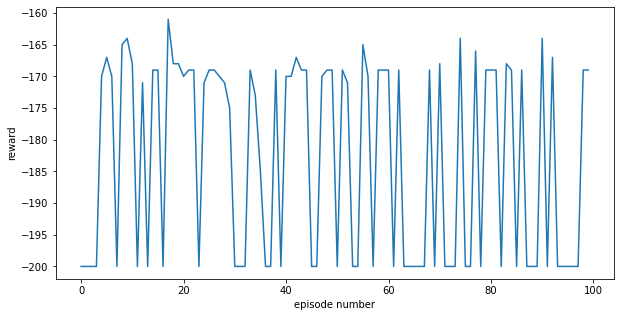

In [17]:
# test the learned policy
test(Q_off_policy_expected_sarsa, 0, 100)

## Comparision of TD(0) methods

The graphs of reward vs episode above shows the learning behaviour of all three methods. All the methods work best with different values of hyperparameters. However, to make comparision, the parameters (such as number of training episodes, epsilon, alpha, etc.) are kept same for all the methods.

The table below summarizes the performce of each method after training for 20,000 episodes. 

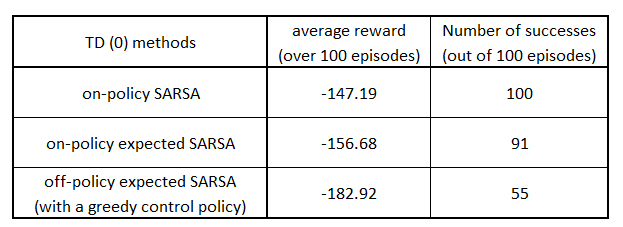

On-policy SARSA performed the best among TD(0) methods tested. It achieved the goal 100% of the time during testing.

# Exercise 2: TD(n)

### a. n-step SARSA (on-policy) control

In [6]:
def n_step_sarsa(env, state_space, action_space, descritizer,
            max_episodes = 50000, GAMMA = 1.0,
            EPS_MAX = 1.0, EPS_MIN = 0.05,   
            ALPHA = 0.1, n=1):
    
    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX
    
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0

    scores = []

    for episode in range(max_episodes):
        T = inf
        t = 0

        # storage
        states = [0]*(n+1)
        actions = [0]*(n+1)
        rewards = [0]*(n+1)

        # initialize S and store
        obs = env.reset()
        S = descritizer(*obs)
        states[t % (n+1)] = S

        # choose A and store
        A = e_greedy(Q, eps, S)
        actions[t % (n+1)] = A

        score = 0
        while True:
            if t < T:
                # take action A, observe R and S_next
                obs, R, done, _ = env.step(A)
                S = descritizer(*obs)

                score += R

                # store R and S_next
                rewards[(t+1) % (n+1)] = R
                states[(t+1) % (n+1)] = S

                if done:
                    T = t + 1
                else:
                    # choose and store A_next
                    A = e_greedy(Q, eps, S)
                    actions[(t+1) % (n+1)] = A

            tau = t - n + 1
            if tau >= 0:
                G = [GAMMA**(i-tau-1)*rewards[i % (n+1)]
                     for i in range(tau+1, min(tau+n, T) + 1)]
                G = np.sum(G)

                if tau + n < T:
                    s = states[(tau+n) % (n+1)]
                    a = actions[(tau+n) % (n+1)]
                    G += (GAMMA**n) * Q[(s, a)]

                s = states[tau % (n+1)]
                a = actions[tau % (n+1)]
                Q[(s, a)] += ALPHA*(G-Q[(s, a)])

            t += 1
            if tau == T - 1:
                break
        
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        
        if episode % 1000 == 0:
            print('episode:', episode, '| avg_reward for last 1000 episodes: %.1f' % avg_score)
            
    return Q, scores

### b. off-policy Tree Backup control

In [10]:
def n_step_Tree_Backup(env, state_space, action_space, descritizer,
                       max_episodes=50000, GAMMA=1.0,
                       EPS_MAX = 1.0, EPS_MIN = 0.0,
                       ALPHA=0.1, n=1):

    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX

    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0

    scores = []
    
    for episode in range(max_episodes):        
        T = inf
        t = 0

        # storage for S,A,R
        states = [0]*(n+1)
        actions = [0]*(n+1)
        rewards = [0]*(n+1)

        # initialize S and store
        obs = env.reset()
        S = descritizer(*obs)
        states[t % (n+1)] = S

        # choose A and store
        A = e_greedy(Q, eps, S)
        actions[t % (n+1)] = A

        score = 0
        while True:
            if t < T:
                # take action A, observe R and S_next
                obs, R, done, _ = env.step(A)
                S = descritizer(*obs)

                score += R

                # store R and S_next
                rewards[(t+1) % (n+1)] = R
                states[(t+1) % (n+1)] = S

                if done:
                    T = t + 1
                else:
                    # choose and store A_next
                    A = e_greedy(Q, eps, S)
                    actions[(t+1) % (n+1)] = A

            tau = t + 1 - n
            if tau >= 0:
                if t+1 >= T:
                    G = R
                else:
                    # target policy is greedy w.r.t to Q
                    Q_max = max([ Q[(S, a)] for a in action_space]) 
                    G = R + GAMMA*Q_max
                    
                # Loop for k = min(t, T − 1) down through tau + 1:
                for k in range(min(t, T-1), tau+1 + 1):
                    S_k = states[(k) % (n+1)]
                    A_k = actions[(k) % (n+1)]
                    R_k = rewards[(k) % (n+1)]
                    
                    # target policy is greedy w.r.t to Q
                    A_greedy = np.argmax([ Q[(S_k, a)] for a in action_space])
                    
                    if A_k == A_greedy:
                        G = R_k + GAMMA*G
                    else:
                        G = R_k + GAMMA*Q[(S_k, A_greedy)]

                s = states[tau % (n+1)]
                a = actions[tau % (n+1)]
                Q[(s, a)] += ALPHA*(G-Q[(s, a)])

            t += 1
            if tau == T - 1:
                break
                
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])

        if episode % 1000 == 0:
            print('episode ', episode, 'avg_reward for last 1000 episodes: %.1f' % avg_score)
            
    return Q, scores

# Task 2: n-SARSA

In this task, the n-step SARSA implmented in exercise 2 is used.

### a. n-SARSA TD(2)

In [7]:
Q_n_step_sarsa_2, rewards_n_step_sarsa_2 = n_step_sarsa(env = mc_env, 
                                                state_space = mc_state_space,
                                                action_space = mc_action_space,
                                                descritizer = mc_discretizer,
                                                max_episodes = 20000,
                                                n=2)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -200.0
episode: 7000 | avg_reward for last 1000 episodes: -199.6
episode: 8000 | avg_reward for last 1000 episodes: -192.5
episode: 9000 | avg_reward for last 1000 episodes: -181.9
episode: 10000 | avg_reward for last 1000 episodes: -188.6
episode: 11000 | avg_reward for last 1000 episodes: -151.7
episode: 12000 | avg_reward for last 1000 episodes: -162.7
episode: 13000 | avg_reward for last 1000 episodes: -176.3
episode: 14000 | avg_reward for last 1000 episodes: -158.6
episode: 15000 | avg_reward for last 1000 episodes: -165.6
episode: 16000 | avg_reward for last 1000 episodes: -150.7
episode: 1

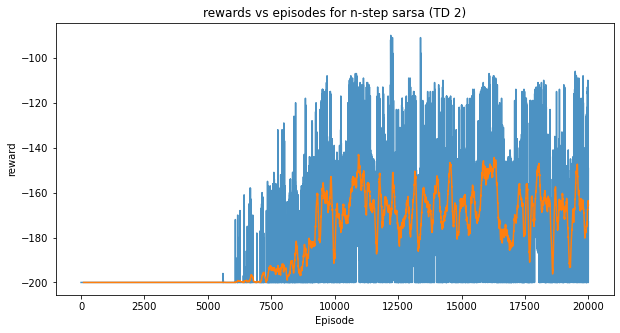

In [8]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_n_step_sarsa_2)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for n-step sarsa (TD 2)')
plt.show()

Average reward over 100 episodes: -170.03
number of successes (reward >= -199) in 100 episodes: 53


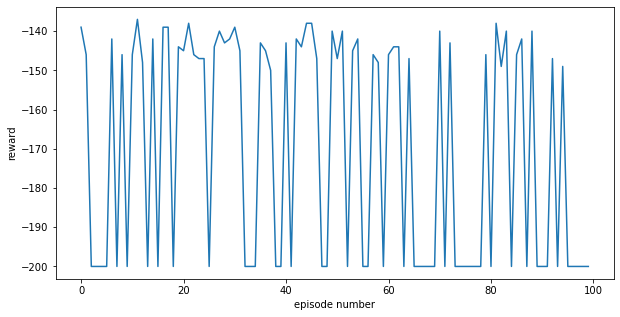

In [10]:
# test the learned policy
test(Q_n_step_sarsa_2, 0, 100)

### b. n-SARSA TD(3)

In [7]:
Q_n_step_sarsa_3, rewards_n_step_sarsa_3 = n_step_sarsa(env = mc_env, 
                                                state_space = mc_state_space,
                                                action_space = mc_action_space,
                                                descritizer = mc_discretizer,
                                                max_episodes = 20000,
                                                n=3)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -200.0
episode: 7000 | avg_reward for last 1000 episodes: -198.6
episode: 8000 | avg_reward for last 1000 episodes: -191.1
episode: 9000 | avg_reward for last 1000 episodes: -182.7
episode: 10000 | avg_reward for last 1000 episodes: -154.9
episode: 11000 | avg_reward for last 1000 episodes: -189.5
episode: 12000 | avg_reward for last 1000 episodes: -179.3
episode: 13000 | avg_reward for last 1000 episodes: -165.6
episode: 14000 | avg_reward for last 1000 episodes: -158.2
episode: 15000 | avg_reward for last 1000 episodes: -149.8
episode: 16000 | avg_reward for last 1000 episodes: -156.9
episode: 1

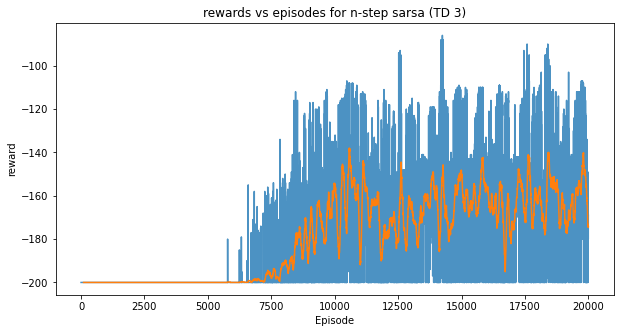

In [8]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_n_step_sarsa_3)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for n-step sarsa (TD 3)')
plt.show()

Average reward over 100 episodes: -185.34
number of successes (reward >= -199) in 100 episodes: 53


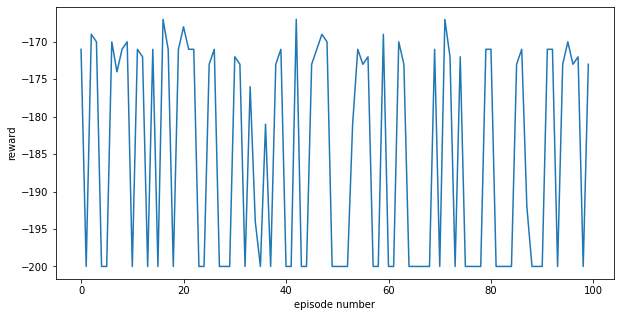

In [10]:
# test the learned policy
test(Q_n_step_sarsa_3, 0, 100)

### c. n-SARSA TD(4)

In [7]:
Q_n_step_sarsa_4, rewards_n_step_sarsa_4 = n_step_sarsa(env = mc_env, 
                                                state_space = mc_state_space,
                                                action_space = mc_action_space,
                                                descritizer = mc_discretizer,
                                                max_episodes = 20000,
                                                n=4)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -199.7
episode: 7000 | avg_reward for last 1000 episodes: -198.4
episode: 8000 | avg_reward for last 1000 episodes: -183.6
episode: 9000 | avg_reward for last 1000 episodes: -175.0
episode: 10000 | avg_reward for last 1000 episodes: -149.7
episode: 11000 | avg_reward for last 1000 episodes: -157.0
episode: 12000 | avg_reward for last 1000 episodes: -166.0
episode: 13000 | avg_reward for last 1000 episodes: -172.7
episode: 14000 | avg_reward for last 1000 episodes: -162.8
episode: 15000 | avg_reward for last 1000 episodes: -163.6
episode: 16000 | avg_reward for last 1000 episodes: -168.9
episode: 1

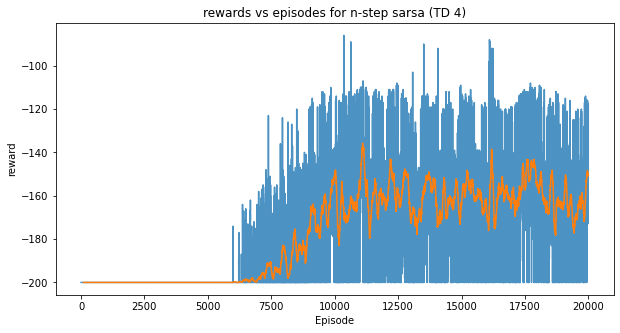

In [8]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_n_step_sarsa_4)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for n-step sarsa (TD 4)')
plt.show()

Average reward over 100 episodes: -143.43
number of successes (reward >= -199) in 100 episodes: 100


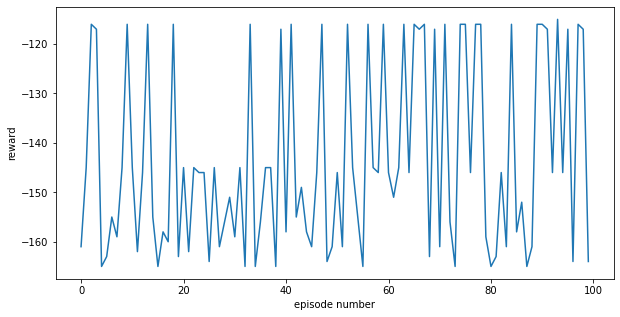

In [10]:
# test the learned policy
test(Q_n_step_sarsa_4, 0, 100)

## Comparision of TD(0) with TD(n) using n-SARSA for n=2,3,4

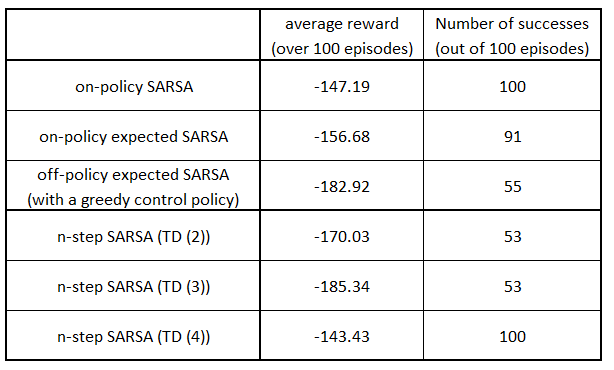

Among TD(0) and TD(n) with SARSA control, TD(4) performed the best for both the matrics. This perfromance is not indicative of true perfromance as hyperparameters are not tuned.

# Bonus Task 3: Tree Backup

### a. Tree Backup for TD(2)

In [11]:
 Q_tree_bakcup_2, rewards_tree_backup_2 = n_step_Tree_Backup(mc_env,
                                                  mc_state_space,
                                                  mc_action_space,
                                                  mc_discretizer,
                                                  max_episodes=20000,
                                                  n = 2)

episode  0 avg_reward for last 1000 episodes: -200.0
episode  1000 avg_reward for last 1000 episodes: -200.0
episode  2000 avg_reward for last 1000 episodes: -200.0
episode  3000 avg_reward for last 1000 episodes: -200.0
episode  4000 avg_reward for last 1000 episodes: -200.0
episode  5000 avg_reward for last 1000 episodes: -200.0
episode  6000 avg_reward for last 1000 episodes: -200.0
episode  7000 avg_reward for last 1000 episodes: -199.2
episode  8000 avg_reward for last 1000 episodes: -191.2
episode  9000 avg_reward for last 1000 episodes: -182.1
episode  10000 avg_reward for last 1000 episodes: -166.4
episode  11000 avg_reward for last 1000 episodes: -140.8
episode  12000 avg_reward for last 1000 episodes: -139.6
episode  13000 avg_reward for last 1000 episodes: -137.2
episode  14000 avg_reward for last 1000 episodes: -139.4
episode  15000 avg_reward for last 1000 episodes: -140.0
episode  16000 avg_reward for last 1000 episodes: -139.6
episode  17000 avg_reward for last 1000 epis

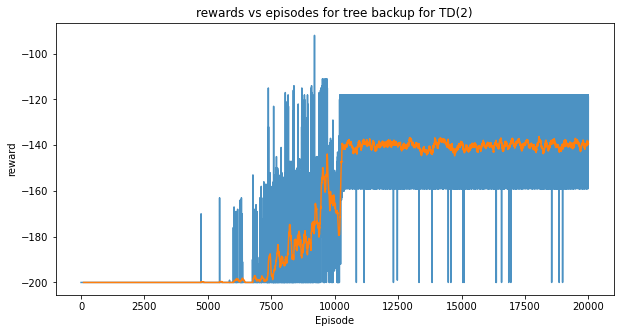

In [15]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_tree_backup_2)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for tree backup for TD(2)')
plt.show()

Average reward over 100 episodes: -140.12
number of successes (reward >= -199) in 100 episodes: 100


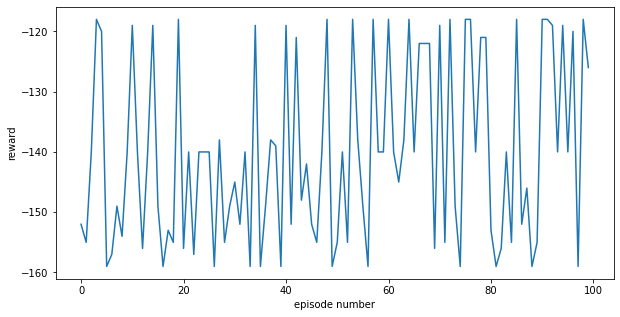

In [16]:
# test the learned policy
test(Q_tree_bakcup_2, 0, 100)

### b. Tree Backup for TD(3)

In [7]:
 Q_tree_bakcup_3, rewards_tree_backup_3 = n_step_Tree_Backup(mc_env,
                                                  mc_state_space,
                                                  mc_action_space,
                                                  mc_discretizer,
                                                  max_episodes=20000,
                                                  n = 3)

episode  0 avg_reward for last 1000 episodes: -200.0
episode  1000 avg_reward for last 1000 episodes: -200.0
episode  2000 avg_reward for last 1000 episodes: -200.0
episode  3000 avg_reward for last 1000 episodes: -200.0
episode  4000 avg_reward for last 1000 episodes: -200.0
episode  5000 avg_reward for last 1000 episodes: -200.0
episode  6000 avg_reward for last 1000 episodes: -200.0
episode  7000 avg_reward for last 1000 episodes: -198.4
episode  8000 avg_reward for last 1000 episodes: -187.1
episode  9000 avg_reward for last 1000 episodes: -172.4
episode  10000 avg_reward for last 1000 episodes: -116.9
episode  11000 avg_reward for last 1000 episodes: -115.4
episode  12000 avg_reward for last 1000 episodes: -113.0
episode  13000 avg_reward for last 1000 episodes: -112.2
episode  14000 avg_reward for last 1000 episodes: -111.0
episode  15000 avg_reward for last 1000 episodes: -111.6
episode  16000 avg_reward for last 1000 episodes: -112.5
episode  17000 avg_reward for last 1000 epis

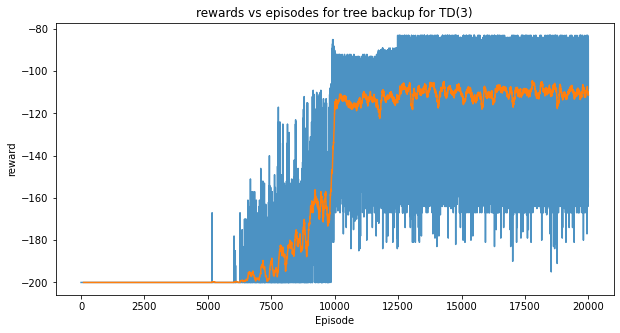

In [11]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_tree_backup_3)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for tree backup for TD(3)')
plt.show()

Average reward over 100 episodes: -108.49
number of successes (reward >= -199) in 100 episodes: 100


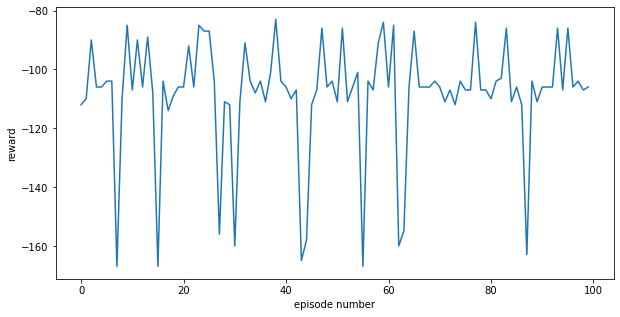

In [12]:
# test the learned policy
test(Q_tree_bakcup_3, 0, 100)

### c. Tree Backup for TD(4)

In [11]:
 Q_tree_bakcup_4, rewards_tree_backup_4 = n_step_Tree_Backup(mc_env,
                                                  mc_state_space,
                                                  mc_action_space,
                                                  mc_discretizer,
                                                  max_episodes=20000,
                                                  n = 4)

episode  0 avg_reward for last 1000 episodes: -200.0
episode  1000 avg_reward for last 1000 episodes: -200.0
episode  2000 avg_reward for last 1000 episodes: -200.0
episode  3000 avg_reward for last 1000 episodes: -200.0
episode  4000 avg_reward for last 1000 episodes: -200.0
episode  5000 avg_reward for last 1000 episodes: -200.0
episode  6000 avg_reward for last 1000 episodes: -199.0
episode  7000 avg_reward for last 1000 episodes: -195.7
episode  8000 avg_reward for last 1000 episodes: -191.9
episode  9000 avg_reward for last 1000 episodes: -165.8
episode  10000 avg_reward for last 1000 episodes: -148.7
episode  11000 avg_reward for last 1000 episodes: -144.0
episode  12000 avg_reward for last 1000 episodes: -141.4
episode  13000 avg_reward for last 1000 episodes: -138.3
episode  14000 avg_reward for last 1000 episodes: -142.3
episode  15000 avg_reward for last 1000 episodes: -142.2
episode  16000 avg_reward for last 1000 episodes: -142.7
episode  17000 avg_reward for last 1000 epis

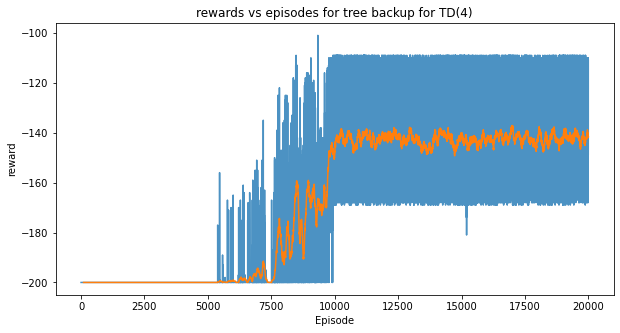

In [14]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_tree_backup_4)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for tree backup for TD(4)')
plt.show()

Average reward over 100 episodes: -142.68
number of successes (reward >= -199) in 100 episodes: 100


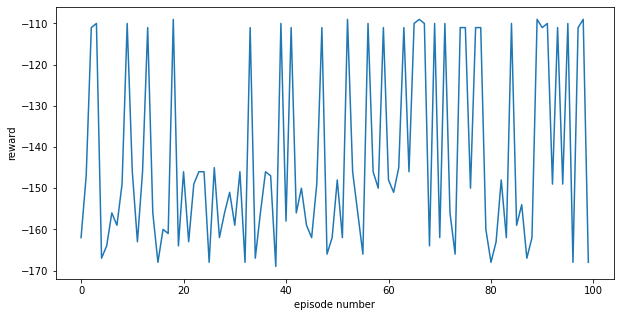

In [17]:
# test the learned policy
test(Q_tree_bakcup_4, 0, 100)

## Comparision of TD(n) using Tree Backup, TD(0), and TD(n) using n-SARSA for n=2,3,4

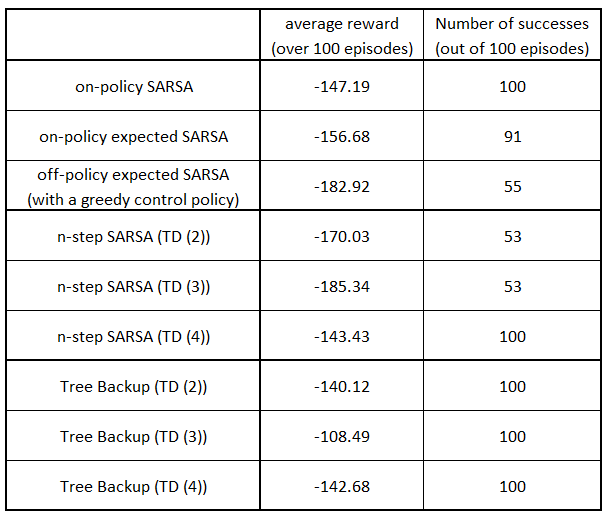

Among all the methods tested, Tree backup with TD(3) perfromed the best. It also achieved optimal perfromce in terms of the avergae reward, taking 108 steps on average to reach the goal. All Tree backup methods performed better than n-step sarsa and TD(0) methods on average. While other methods (on-policy sarsa and n-step sarsa with TD(4)) also achieved goal 100% of the time, the number of steps taken were not the optimal on average.  